# Time Series Forecasting using Machine Learning models

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from green_city.utils import index2datetime
from green_city.regression import plot_ts, error_metrics, train_test_time_split
from green_city.regression import seasons, time_of_day, forecast_dates

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [45]:
building_nr = "all"
column_to_predict = "net_load_kWh"

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "building_nr": building_nr,
    "predicted_feature": column_to_predict,
    "resolution": "daily",
}

In [51]:
# Set write_date to True for logging to mlflow and SQL database
write_data = False

if write_data:
    
    # ## MLFLOW ##
    try:
        import mlflow
        from green_city.mlflow_config import get_mlflow_config

        flow_conf = get_mlflow_config()
        tracking_uri = flow_conf["TRACKING_URI"]
        mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
        mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);
    except:
        print("mlflow ui not active")


    # ## DB CONNECTION ##
    from sqlalchemy import create_engine
    from decouple import Config, RepositoryEnv

    config = Config(RepositoryEnv("../.db_credentials"))
    db_connection_credentials = {
        "database": config('POSTGRES_DB'),
        "user": config('POSTGRES_USER'),
        "password": config('POSTGRES_PASSWORD'),
        "host": config('POSTGRES_HOST'),
        "port": config('POSTGRES_PORT'),
    }
    DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
    db = create_engine(DB_STRING)

In [47]:
# Load data
if building_nr == 'all':
    df = pd.read_csv(f"../data/preprocessed/Agg_buildings.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
else:
    df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
df.fillna(0.0, inplace=True)

In [48]:
# Add additional columns for time
df['hour'] = df.index.hour.astype('category')
df['month'] = df.index.month.astype('category')
df['year'] = df.index.year.astype('category')
df['holiday'] = df['holiday'].astype('category')
df['workday'] = df['workday'].astype('category')

df['season'] = df['month'].apply(seasons).astype('category')
df['time_of_day'] = df['hour'].apply(time_of_day).astype('category')
df['day_of_week'] = df.index.day_of_week.astype('category')

# Creating lag variables
for i in range(24):
    df['net_load_kW_lag'+str(i+1)] = df['net_load_kW'].shift(i+1)
df['net_load_kW_lag168'] = df['net_load_kW'].shift(24*7)

# Exogenous variables for yearly, weekly and hourly seasonality
df['year_sin365'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
df['year_cos365'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
df['year_sin365_2'] = np.sin(4 * np.pi * df.index.dayofyear / 365)
df['year_cos365_2'] = np.cos(4 * np.pi * df.index.dayofyear / 365)
df['week_sin365'] = np.sin(2 * np.pi * df.index.dayofweek/7)
df['week_cos365'] = np.cos(2 * np.pi * df.index.dayofweek/7)
df['week_sin365_2'] = np.sin(4 * np.pi * df.index.dayofweek/7)
df['week_cos365_2'] = np.cos(4 * np.pi * df.index.dayofweek/7)
df['hour_sin365'] = np.sin(2 * np.pi * df.index.hour/24)
df['hour_cos365'] = np.cos(2 * np.pi * df.index.hour/24) 
df['hour_sin365_2'] = np.sin(4 * np.pi * df.index.hour/24)
df['hour_cos365_2'] = np.cos(4 * np.pi * df.index.hour/24) 

# Shift predicted weather values by 24hr
df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_hum_shift'] = df['pred_24h_outdoor_hum'].shift(periods=24)
df = df.dropna()

## Lasso Regression

In [6]:
# Include weather features for random forest regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag24', 'net_load_kW_lag168',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Scaling features
scaled_features = X_train.columns[X_train.dtypes == 'float64'].to_list()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Create the model
model_lasso = Lasso(alpha=0.01)

# Fit on training data
model_lasso.fit(X_train_scaled, y_train)

# Predict train and test data
y_pred_train = model_lasso.predict(X_train_scaled)
y_pred_test = model_lasso.predict(X_test_scaled)
df_test['lasso'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Lasso Regression")                                                        

----------------------------------------
Lasso Regression
----------------------------------------
R2 (train): 0.9
R2 (test) : 0.848
MAE (test): 44.161
MSE (test): 3703.428
RMSE(test): 60.856


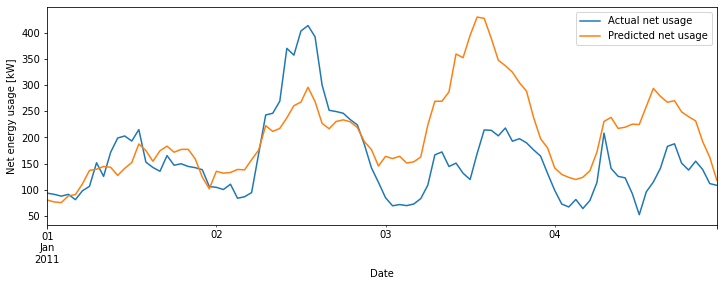

In [7]:
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['lasso'].iloc[0:24*4])

In [8]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"alpha": np.linspace(0.05, 0.15, 11)
             }

# Do a randomized search
lasso_gscv = GridSearchCV(
                estimator=Lasso(random_state=RSEED),
                param_grid=param_grid,
                cv=tscv, verbose=2, n_jobs=-1)

# Fit train data
model_lasso = lasso_gscv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.1s
[CV] END .........................................alpha=0.06; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.1s
[CV] END .........................................alpha=0.07; total time=   0.1s
[CV] END .........................................alpha=0.06; total time=   0.1s
[CV] END .........................................alpha=0.07; total time=   0.0s
[CV] END .........................................alpha=0.06; total time=   0.1s
[CV] END .........................................alpha=0.08; total time=   0.0s
[CV] END .........................................alpha=0.08; total time=   0.1s
[CV] END .........................................alpha=0.07; total time=   0.1s
[CV] END .......................................

In [9]:
print("Best model:", lasso_gscv.best_params_)

best_model = lasso_gscv.best_estimator_
best_params = lasso_gscv.best_params_

y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

df_train['lasso'] = y_pred_train
df_test['lasso'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Lasso regression")

Best model: {'alpha': 0.15}
----------------------------------------
Lasso regression
----------------------------------------
R2 (train): 0.899
R2 (test) : 0.849
MAE (test): 43.862
MSE (test): 3682.605
RMSE(test): 60.684


In [10]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag24', 'net_load_kW_lag168', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Scaling features
scaled_features = X_train.columns[X_train.dtypes == 'float64'].to_list()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scaled_features] = scaler.transform(X_train_scaled[scaled_features])
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Predict train and test data
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)
df_test['lasso'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Lasso Regression")                                                               

----------------------------------------
Lasso Regression
----------------------------------------
R2 (train): 0.897
R2 (test) : 0.847
MAE (test): 44.194
MSE (test): 3727.329
RMSE(test): 61.052


Day: 2011-09-01 23:00:00, mae: 54.019, mse: 3923.531, rmse: 62.638, r2: 0.807
Day: 2011-10-20 23:00:00, mae: 24.801, mse: 950.163, rmse: 30.825, r2: 0.939
Day: 2011-01-09 06:00:00, mae: 29.894, mse: 1310.197, rmse: 36.197, r2: 0.315
Day: 2011-10-22 21:00:00, mae: 25.218, mse: 1142.607, rmse: 33.802, r2: 0.599
Day: 2011-06-21 03:00:00, mae: 37.275, mse: 2177.495, rmse: 46.664, r2: 0.904
Day: 2011-07-08 02:00:00, mae: 39.830, mse: 2487.296, rmse: 49.873, r2: 0.885
Day: 2011-08-19 00:00:00, mae: 39.869, mse: 4022.472, rmse: 63.423, r2: 0.906
Day: 2011-04-15 07:00:00, mae: 18.879, mse: 565.934, rmse: 23.789, r2: 0.905
Avg mae: 33.723, Avg mse: 2072.462, Avg rmse: 45.524, Avg r2: 0.905


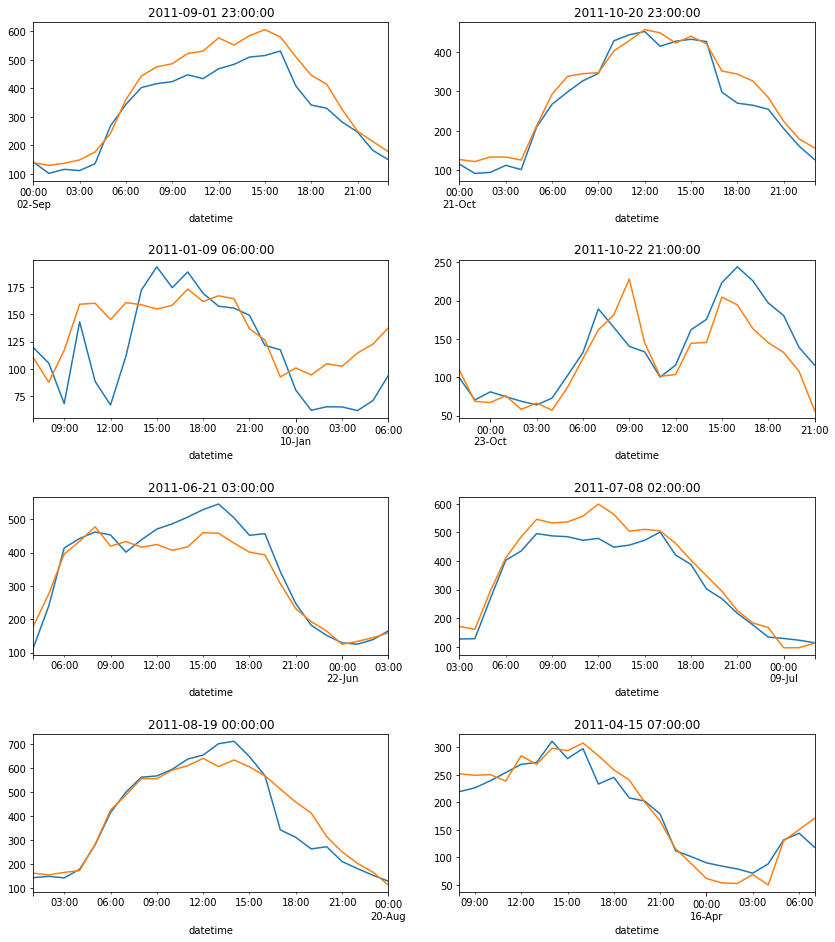

In [11]:
forecast_dates(df_test, "lasso", global_params, write_data)

## Random forest regression

We first train the model based on the measured weather data. We then use the trained model to forecast the net energy usage based on the 24h predicted weather data.

### Random forest regression with 1h and 24h lagged values and Fourier terms for daily, weekly and yearly seasonality

In [220]:
# Include weather features for random forest regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag24', 'net_load_kW_lag168',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Create the model
#rf = RandomForestRegressor(random_state=RSEED)

rf = RandomForestRegressor(max_depth=9, min_samples_leaf=10, min_samples_split=7, 
                            n_estimators=200, random_state=RSEED)

# Fit on training data
rf.fit(X_train, y_train)

# Predict train and test data
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
df_test['random_forest'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random Forest Regressor")                                                        

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.883
R2 (test) : 0.821
MAE (test): 3.577
MSE (test): 21.903
RMSE(test): 4.68


In [221]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag24', 'net_load_kW_lag168', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Predict 
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")

forecasts = df_test[['net_load_kW','random_forest','outdoor_temp','outdoor_hum']]
forecasts["datetime"] = forecasts.index
filename = '../data/models/random_forest_building_'+str(building_nr)+'.pkl'
forecasts.to_pickle(filename)

----------------------------------------
Random forest
----------------------------------------
R2 (train): 0.868
R2 (test) : 0.815
MAE (test): 3.643
MSE (test): 22.64
RMSE(test): 4.758


<AxesSubplot:>

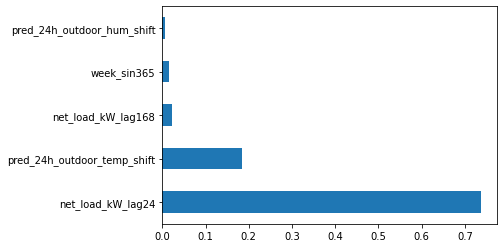

In [148]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')

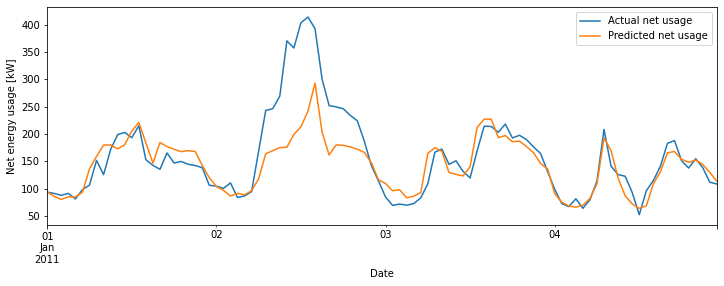

In [117]:
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['y_pred_test'].iloc[0:24*4])

### Run random search with cross validation to narrow down optimal hyperparameters

In [118]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"min_samples_split": [5, 6, 7, 8, 9],
                "min_samples_leaf": [10, 20, 30, 50, 100],
                "max_depth": [6, 7, 8, 9],
                "n_estimators": [100, 150, 200, 250, 300]
            }

# Do a randomized search
rscv = RandomizedSearchCV(
                estimator=RandomForestRegressor(random_state=RSEED),
                param_distributions=param_grid,
                cv=tscv, n_iter=20, verbose=2, n_jobs=-1)

# Fit train data
rf_search = rscv.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=6, min_samples_leaf=20, min_samples_split=9, n_estimators=200; total time=   4.7s
[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=9, n_estimators=200; total time=   4.7s
[CV] END max_depth=7, min_samples_leaf=100, min_samples_split=8, n_estimators=250; total time=   5.3s
[CV] END max_depth=6, min_samples_leaf=20, min_samples_split=5, n_estimators=150; total time=   3.8s
[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=9, n_estimators=200; total time=   9.6s
[CV] END max_depth=6, min_samples_leaf=20, min_samples_split=9, n_estimators=200; total time=   9.8s
[CV] END max_depth=7, min_samples_leaf=100, min_samples_split=8, n_estimators=250; total time=  12.5s
[CV] END max_depth=6, min_samples_leaf=20, min_samples_split=5, n_estimators=150; total time=   7.4s
[CV] END max_depth=6, min_samples_leaf=20, min_samples_split=9, n_estimators=200; total time=  15.2s
[CV] END max_depth=8, min_sa

In [119]:
print("Best model:", rf_search.best_params_)

rf_model = rf_search.best_estimator_
rf_params = rf_search.best_params_

y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")

Best model: {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_depth': 8}
----------------------------------------
Random forest
----------------------------------------
R2 (train): 0.972
R2 (test) : 0.907
MAE (test): 31.591
MSE (test): 2267.405
RMSE(test): 47.617


### Grid search to find the optimal hyperparameters

In [120]:
tscv = TimeSeriesSplit(n_splits=3)

estimator = RandomForestRegressor(random_state=RSEED)

param_grid = {"min_samples_split": [7, 8, 9],
                "min_samples_leaf": [10, 20, 30],
                "max_depth": [7, 8, 9],
                "n_estimators": [150, 200, 250]
            }

gsc = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=tscv, scoring='r2', verbose=2, n_jobs=-1)

grid_search = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=150; total time=   4.3s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=200; total time=   5.5s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=250; total time=   7.0s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=150; total time=   8.4s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=8, n_estimators=150; total time=   4.1s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=200; total time=  11.4s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=150; total time=  12.9s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=250; total time=  14.4s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=8, n_estimators=200; total time=   5.5s
[CV] END max_depth=7, min_sam

In [121]:
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random Forest Regressor")

{'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 200}
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.978
R2 (test) : 0.911
MAE (test): 30.354
MSE (test): 2161.584
RMSE(test): 46.493


In [140]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag24', 'net_load_kW_lag168', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Predict 
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")                                                                                                                

----------------------------------------
Random forest
----------------------------------------
R2 (train): 0.967
R2 (test) : 0.903
MAE (test): 32.104
MSE (test): 2366.576
RMSE(test): 48.647


Day: 2011-09-01 23:00:00, mae: 49.442, mse: 3899.449, rmse: 62.446, r2: 0.808
run-uuid: 432546a823ec45218b4882752c282e2c
Day: 2011-10-20 23:00:00, mae: 33.185, mse: 2103.816, rmse: 45.867, r2: 0.865
run-uuid: acffe4280d81400abb0a47717a6fe088
Day: 2011-01-09 06:00:00, mae: 25.624, mse: 1374.400, rmse: 37.073, r2: 0.282
run-uuid: 35e2cc98d2a549ac8a41fdfd8d793e51
Day: 2011-10-22 21:00:00, mae: 26.354, mse: 873.771, rmse: 29.560, r2: 0.694
run-uuid: 5561a8de1f484265bef41bef1170310b
Day: 2011-06-21 03:00:00, mae: 33.912, mse: 1724.800, rmse: 41.531, r2: 0.924
run-uuid: 2952da0054714be1972503be2e5c8c5d
Day: 2011-07-08 02:00:00, mae: 25.297, mse: 1300.662, rmse: 36.065, r2: 0.940
run-uuid: 6c5d83e80c414bfaa4bf04c7ede0dd40
Day: 2011-08-19 00:00:00, mae: 38.152, mse: 2410.441, rmse: 49.096, r2: 0.943
run-uuid: 4644c66fc4a84b72b4a3ccf99ec38b92
Day: 2011-04-15 07:00:00, mae: 26.797, mse: 1246.985, rmse: 35.313, r2: 0.791
run-uuid: 6bb4ffc5f22243929a271bb562ae37af
Avg mae: 32.345, Avg mse: 1866.79

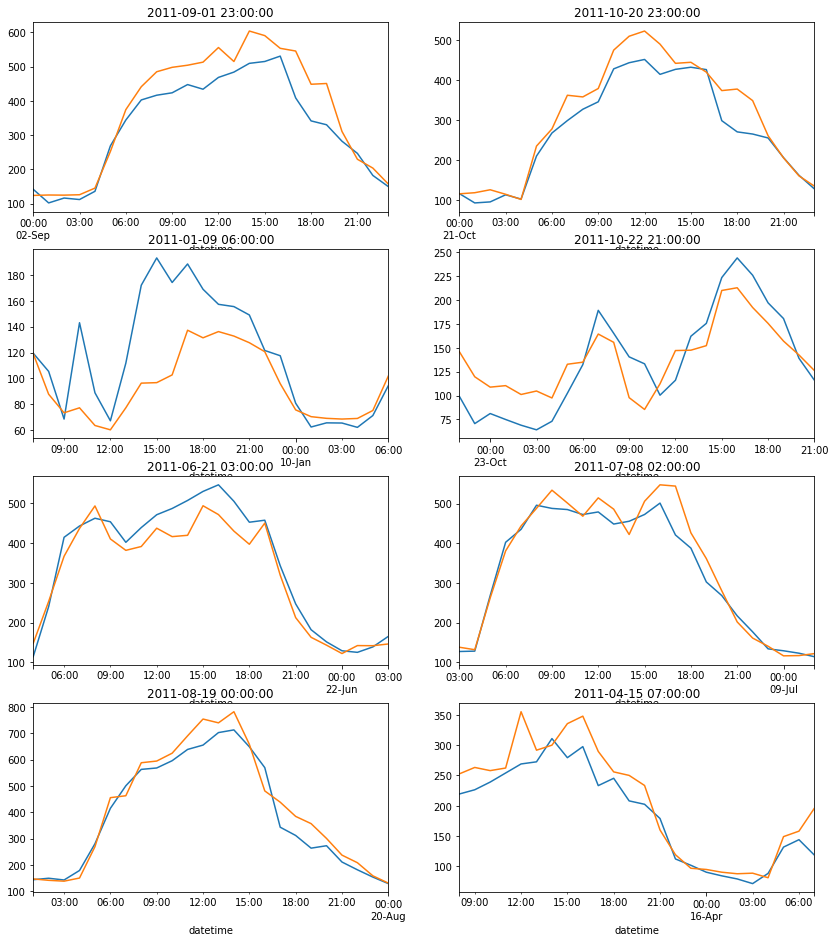

In [50]:
# Using predicted weather to forecast net energy usage
train_features = ['outdoor_temp', 'outdoor_hum', 
                'diffuse_solar_W_m2', 'direct_solar_W_m2', 
                'hour', 'month', 'holiday', 'workday',
                'net_load_kW_lag24', 'net_load_kW_lag168', 
                'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
                'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
                'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Using predicted weather to forecast net energy usage
pred_features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
                'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
                'hour', 'month', 'holiday', 'workday',
                'net_load_kW_lag24', 'net_load_kW_lag168', 
                'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
                'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
                'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']


# Randomly chosen list of indices to forecast
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

mae_list = []
mse_list = []
r2_list = []
forecasts = pd.DataFrame(columns=['prediction','run_id','id'])

fig, ax = plt.subplots(4,2,figsize=(14,16))
i = 1
for index in pred_indices:
    
    day = index2datetime(index)

    # Train test splot
    X_train = df[train_features].loc[:day]
    y_train = df[[target]].loc[:day]
    X_test = df[pred_features].loc[day+pd.DateOffset(hours=1):day+pd.DateOffset(hours=24)]
    y_test = df[[target]].loc[day+pd.DateOffset(hours=1):day+pd.DateOffset(hours=24)]

    rf = RandomForestRegressor(max_depth=9, min_samples_leaf=10, min_samples_split=7, 
                            n_estimators=200, random_state=RSEED)

    # Fit on training data
    rf.fit(X_train, y_train)

    # Predict train and test data
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    X_test['random_forest'] = y_pred_test

    # Print error metrics
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(r2)

    # # Calculate and print error metrics
    _ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random Forest Regressor")       

    # Plot actual vs predicted net energy usage for each of the chosen days
    plt.subplot(4, 2, i)
    y_test['net_load_kW'].plot()
    X_test['random_forest'].plot()
    plt.title(day)
    i = i + 1

    if write_data:
        # Starting the MLFlow run
        r = mlflow.start_run(run_name="random_forest")
        print("run-uuid:", r.info.run_uuid)
        for k, v in global_params.items():
            mlflow.log_param(k, v)
            mlflow.log_param("model", "random_forest")
            mlflow.log_param("datetime", day)
            mlflow.log_param("feature", "net_load_kW")
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("r2_score", r2)
        mlflow.end_run()

        # DataFrame for writing to SQL database
        day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
        day_forecast['prediction'] = y_pred_test
        day_forecast['run_id'] = r.info.run_uuid
        day_forecast['id'] = np.arange(index+1,index+25)
        forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
    forecasts = forecasts.set_index('id')
    forecasts.to_sql("forecast", con=db, if_exists="append")

print(f"Avg mae: {np.mean(mae_list):.3f}, Avg mse: {np.mean(mse_list):.3f}, Avg rmse: {np.sqrt(np.mean(mse_list)):.3f}, Avg r2: {np.mean(r2):.3f}")

## XGBoost

### XGBoost including weather

In [134]:
# Include weather features 
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Fit training data
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=RSEED)
xg_reg.fit(X_train, y_train)  

# Predict on train and test data
y_pred_train = xg_reg.predict(X_train)
y_pred_test = xg_reg.predict(X_test)
df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

----------------------------------------
XGBRegressor
----------------------------------------
R2 (train): 0.995
R2 (test) : 0.968
MAE (test): 18.207
MSE (test): 779.686
RMSE(test): 27.923


In [ ]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"min_samples_split": [5, 6, 7, 8, 10],
                "min_samples_leaf": [5, 10, 20, 50, 80, 100],
                "max_depth": [5, 6, 7, 8],
                "n_estimators": [100, 150, 200, 250, 300]
            }

# Do a randomized search
rscv = RandomizedSearchCV(
                estimator=RandomForestRegressor(random_state=RSEED),
                param_distributions=param_grid,
                cv=tscv, n_iter=20, verbose=2, n_jobs=-1)

# Fit train data
rf_search = rscv.fit(X_train, y_train)

In [27]:
# Grid search cross validation
gsc = GridSearchCV(
        estimator=xgb.XGBRegressor(),
        param_grid={"learning_rate": [0.01, 0.05, 0.10, 0.15],
                    "max_depth": [ 4, 5, 6, 7 ],
                    "n_estimators": [100, 150, 200],
                    },
        cv=tscv, scoring='r2', verbose=2, n_jobs=-1)

grid_search = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   1.5s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=150; total time=   2.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.9s[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   2.9s

[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   4.7s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=150; total time=   4.9s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   6.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=150; total time=   6.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   4.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   3.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_e

In [28]:
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on train and test data
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
----------------------------------------
XGBRegressor
----------------------------------------
R2 (train): 0.922
R2 (test) : 0.844
MAE (test): 3.269
MSE (test): 19.335
RMSE(test): 4.397


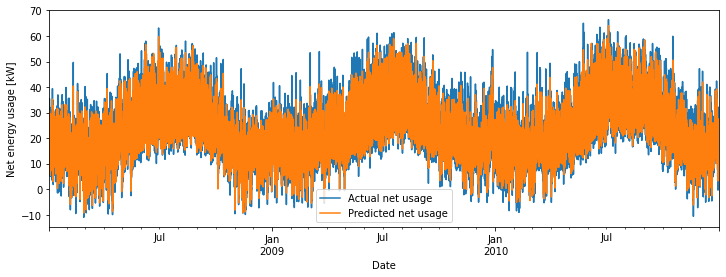

In [51]:
plot_ts(df_train['net_load_kW'], df_train['xgboost'])

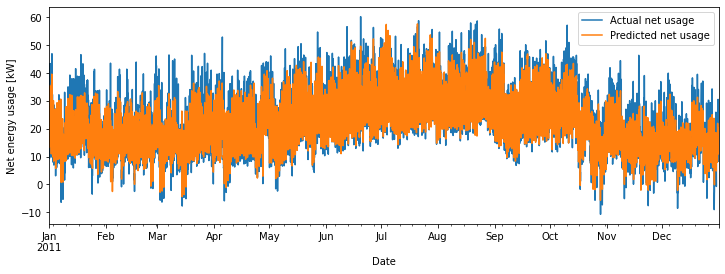

In [52]:
plot_ts(df_test['net_load_kW'], df_test['xgboost'])

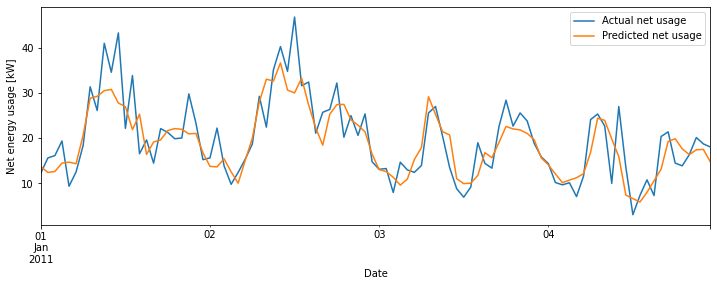

In [78]:
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['xgboost'].iloc[0:24*4])

### XGBoost using weather predictions

In [ ]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'time_of_day', 'season', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['time_of_day', 'season', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

In [30]:
# Forecast using 24h weather predictions 
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")

----------------------------------------
Random forest
----------------------------------------
R2 (train): 0.922
R2 (test) : 0.844
MAE (test): 3.269
MSE (test): 19.335
RMSE(test): 4.397
